In [1]:
from functools import partial

import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt

from plot_dist import plot_est_hist_normal
from emp_dist import EmpiricalDistribution
from parallel import run_parallel

In [2]:
np.random.seed(31337)

# Maximum likelihood estimation

## Recap

* $p_0(z)$ - fixed but unknown true data probability density
* $p(z;\mu)$ - our model density with paramter $\mu$
* $\mu^*(p_0) = \arg \min_{\mu} KL[p_0, p] = \arg \min_{\mu} \int_{\mathbb{R}^n} p_0(z) \log \frac{p_0(z)}{p(z; \mu)} dz$ - our proposed theoretical estimate

We can simplify the optimization target:
$$\mu^*(p_0) = \arg \max_{\mu} \int_{\mathbb{R}^n} p_0(z) \log p(z; \mu) dz$$

Since we don't know the true density, we use empirical analog and get the following:
$$\hat{\mu} = \arg \max_\mu \left\{\log [p(Y_n; \mu)]\right\},$$
which is what we call a \textit{maximum likelihood estimate} of the parameter $\mu$.

## Examples: estimating location parameter.

### Gaussian errors

Consider the following statistical model of the data:
$$Y_i = \mu + \varepsilon_i, \; i=1 \dots n,$$
where $\mu$ is the parameter of interest and the errors are zero-mean Gaussian $\varepsilon_i \sim \mathcal{N}(0, \sigma)$.

As we have seen in the lectures, MLE for the parameter $\mu$ is the sample mean: $\hat{\mu}=\overline{Y}_n$.

Let's recal the parameters from the experiments in the first seminar:

In [3]:
true_mu = 166
true_sigma = np.sqrt(40.32)
num_repeats = 1000

We are often interested of the quality of our estimates. One common measure is mean squared risk:
$$r = \mathbb{E}[(\hat{\mu} - \mu)^2].$$

From the first lecture we know that for our case $\mathbb{E}[(\hat{\mu} - \mu)^2] = \mathbb{E}[(\overline{Y_n} - \mu)^2] = \frac{\sigma^2}{n}$. We can't compute it directly using only a single sample, but we can replicate or experiment with different sample size and compare this theoretical value with the sample analog:

In [4]:
def gaussian_errors_experiment(sample_size, mu=0, sigma=1, num_repeats=10):
    import numpy as np
    
    errors = np.random.normal(loc=0, scale=sigma, size=(num_repeats, sample_size))
    Y = mu + errors
    mY = Y.mean(axis=1)
    r = ((mY - mu) ** 2).mean()
    return {'Sample size': sample_size, 'Average risk': r}

In [5]:
# Sample sizes to use
N = np.arange(10, 250, 1)

exp = partial(gaussian_errors_experiment, 
              mu=true_mu, 
              sigma=true_sigma,
              num_repeats=num_repeats)

avg_risks = run_parallel(exp, N)

In [6]:
df_gaussian = pd.DataFrame(avg_risks).set_index('Sample size').sort_index()
df_gaussian["Theoretical risk"] = true_sigma ** 2 / df_gaussian.index
df_gaussian.head()

,Average risk,Theoretical risk
Sample size,,
10,3.999850,4.032000
11,3.963146,3.665455
12,3.251111,3.360000
13,3.094378,3.101538
14,3.069430,2.880000


Now we plot the behavior of the risk in log-log scale to show the order of convergence:

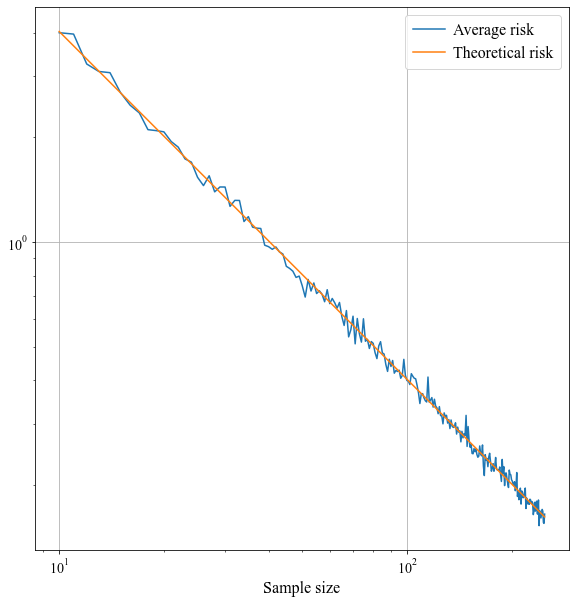

In [7]:
df_gaussian.plot(figsize=(10, 10), grid=True, loglog=True).set_aspect('equal')

To estimate the risk from data we essentially need to estimate $\sigma$. The MLE estimator is just sample variance: $\hat{\sigma}^2 = \overline{\sigma}(Y_n) = \frac{1}{n}\sum_{i=1}^{n} (Y_i - \overline{Y}_n)$. However, this estimator is biased, so sometimes a correction is used: $\hat{\sigma}^2 = \frac{n}{n-1}\overline{\sigma}(Y_n) = \frac{1}{n-1}\sum_{i=1}^{n} (Y_i - \overline{Y}_n)$. 

In [8]:
def gaussian_errors_experiment_ext(sample_size, mu=0, sigma=1, num_repeats=10):
    import numpy as np
    
    errors = np.random.normal(loc=0, scale=sigma, size=(num_repeats, sample_size))
    Y = mu + errors
    mY = Y.mean(axis=1)
    r = ((mY - mu) ** 2).mean()
    ern = np.var(Y, axis=1) / sample_size
    er = np.var(Y, axis=1, ddof=1) / sample_size

    #print(ern, er)
    return {'Sample size': sample_size, 'Average risk': r, 'Risk estimate (naive)': ern.mean(), 'Risk estimate': er.mean()}

In [9]:
exp2 = partial(gaussian_errors_experiment_ext, 
              mu=true_mu, 
              sigma=true_sigma,
              num_repeats=num_repeats)

risks = run_parallel(exp2, np.arange(5, 100))

In [10]:
df_gaussian2 = pd.DataFrame(risks).set_index('Sample size').sort_index()
df_gaussian2["Theoretical risk"] = true_sigma ** 2 / df_gaussian2.index
df_gaussian2.head()

,Average risk,Risk estimate (naive),Risk estimate,Theoretical risk
Sample size,,,,
5,8.688343,6.431761,8.039701,8.064
6,6.847514,5.550162,6.660195,6.720
7,5.524634,4.896851,5.712992,5.760
8,5.383208,4.439422,5.073625,5.040
9,4.167129,3.997447,4.497128,4.480


<AxesSubplot:xlabel='Sample size'>

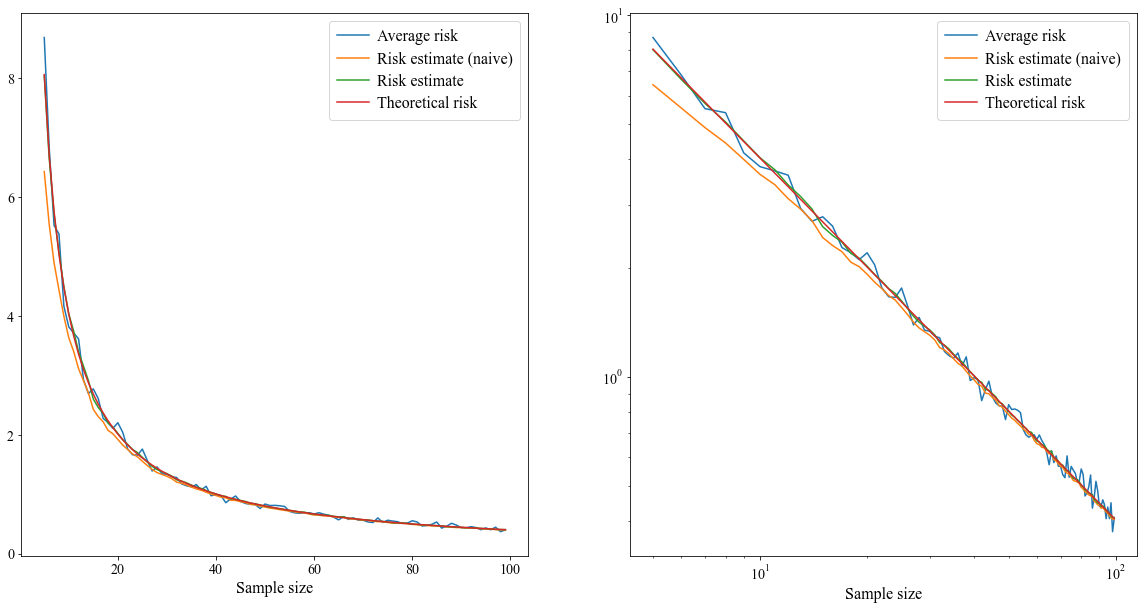

In [38]:
figs, ax = plt.subplots(1, 2, figsize=(20, 10))
df_gaussian2.plot(ax=ax[0])
df_gaussian2.plot(ax=ax[1], logy=True, logx=True)

One important property of MLEs is asymptotic Normality.
Let's check how fast does the sampling distribution of the mean approache the promised Normal distribution.

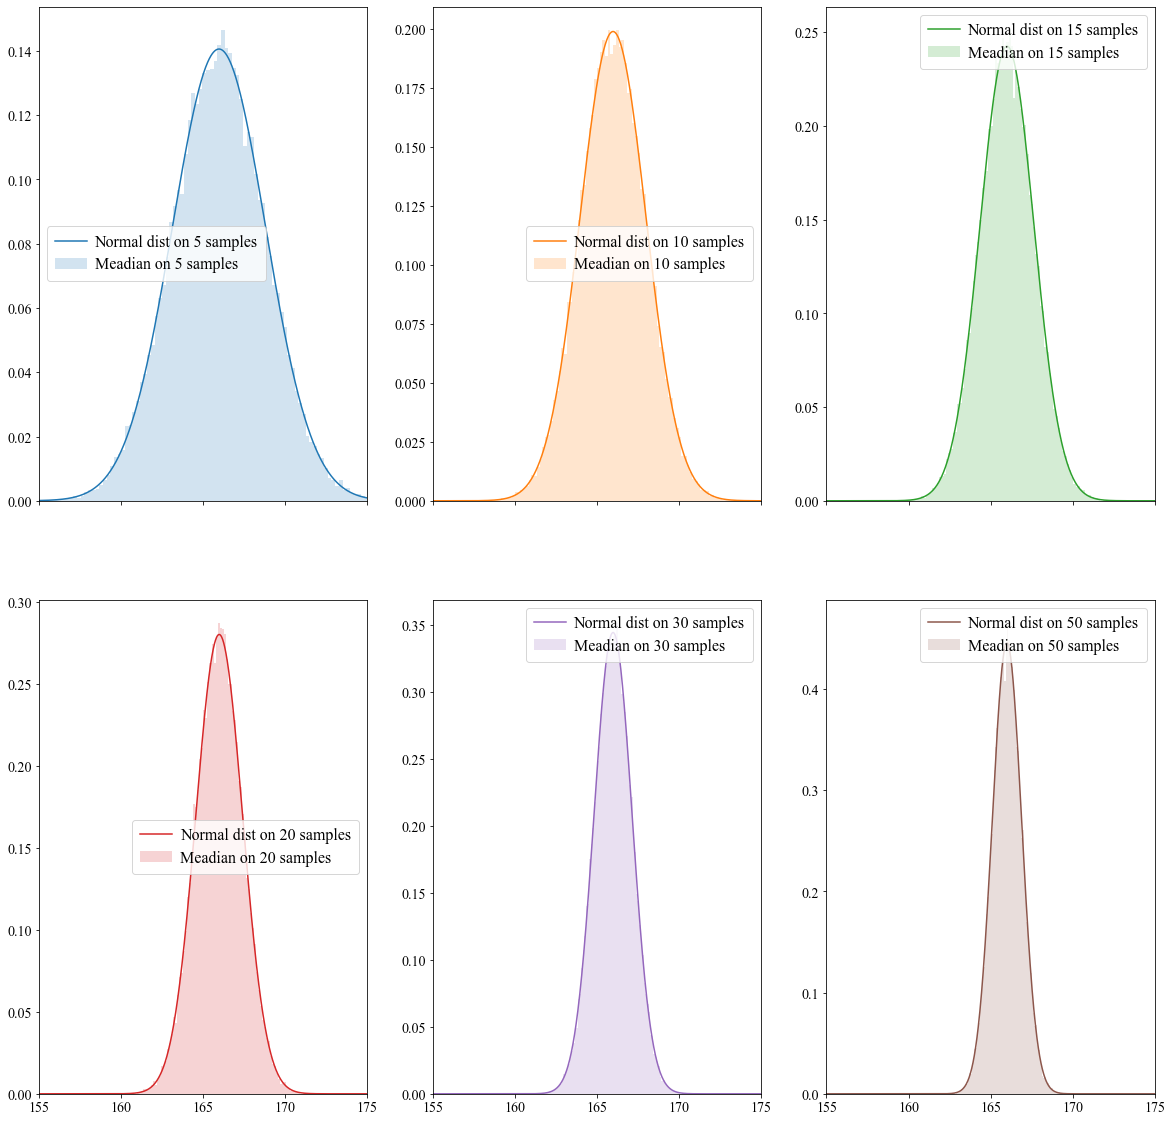

In [12]:
plot_est_hist_normal(error_gen=np.random.normal, 
                     estimator=lambda x: x.mean(axis=1),
                     mu=true_mu,
                     sigma=true_sigma,
                     sample_sizes=[5, 10, 15, 20, 30, 50],
                     num_repeats=num_repeats * 50,
                     x_min=155,
                     x_max=175)

It turns out that for the case of Gaussian errors, the sampling distribution of the sample mean is Gaussian for any sample size! Of course it could be easily derived theoretically.

Summary
* Maximum likelihood estimate of the location parameter in the case of Gaussian noise is just *sample mean* $\overline{Y}^n$
* Reliability of this estimate can be assesed using the following risk estimate: $\widehat{\sigma}^2/n$, where $\widehat{\sigma}$ is an unbiased sample standard deviation estimate, but only *when the model is true*!

### Laplace errors

Now lets consider a slightly differen model:
$$Y_i = \mu + \varepsilon_i, \; i=1 \dots n,$$
where $\mu$ is the parameter of interest but the errors now have a zero-mean Laplace distribution. Density of this distribution is: $$p_{\varepsilon}(z) = \frac{1}{2b} e^{-\frac{|x|}{b}}$$.

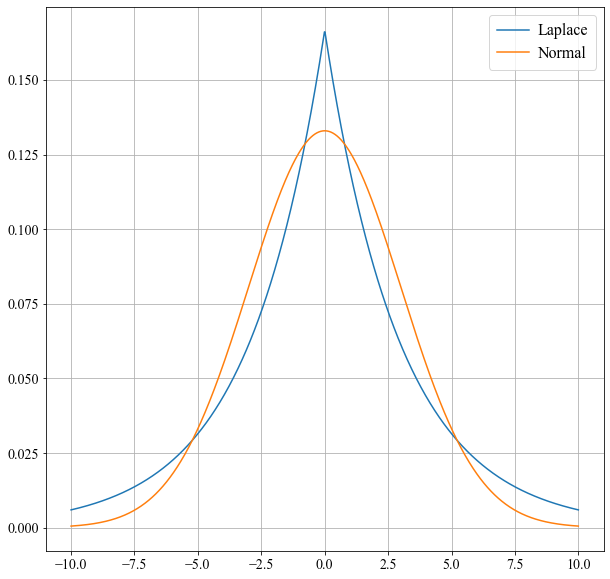

In [13]:
x = np.linspace(-10, 10, 1000)
y1 = scipy.stats.laplace(scale=3).pdf(x)
y2 = scipy.stats.norm(scale=3).pdf(x)
plt.figure(figsize=(10, 10))
plt.plot(x, y1, label='Laplace')
plt.plot(x, y2, label='Normal')
plt.legend()
plt.grid()

A $k$-th ordered statistic is the $k$-th largest value in the sample. Usually, ordered sample is denoted as $Y_{(1)}, Y_{(2)}, \dots, Y_{(n)}$, where $Y_{(1)}$ is the smallest value and $Y_{(n)}$ is the largest.

For the case of the Laplace errors, MLE estimate for $\mu$ is the *sample median*: $\hat{\mu}(Y_n) = Y_{(\lfloor n/2 \rfloor)}$.

In [14]:
def laplace_errors_experiment(sample_size, mu=0, sigma=1, num_repeats=10):
    import numpy as np
    
    errors = np.random.laplace(loc=0, scale=sigma, size=(num_repeats, sample_size))
    Y = mu + errors
    mY = np.median(Y, axis=1)
    r = ((mY - mu) ** 2).mean()

    return {'Sample size': sample_size, 'Average risk': r}

In [15]:
# Sample sizes to use
N = np.arange(10, 500, 1)

exp3 = partial(laplace_errors_experiment, 
              mu=true_mu, 
              sigma=true_sigma,
              num_repeats=num_repeats)

laplace_risks = run_parallel(exp3, N)

$$\sigma^2 = Var[Y_n] = 2b^2$$
$$\widehat{b} = \frac{1}{n}\sum_{i=1}^{n} |Y_i - \widehat{\mu}|$$
$$\widehat{\sigma} = \sqrt{2}\widehat{b}$$

In [41]:
df_laplace = pd.DataFrame(laplace_risks).set_index('Sample size').sort_index()
df_laplace[r"$\frac{\sigma^2}{n}$"] = 2 * true_sigma ** 2 / df_laplace.index
df_laplace.head()

,Average risk,$\frac{\sigma^2}{n}$
Sample size,,
10,5.881267,8.064000
11,5.490333,7.330909
12,4.861775,6.720000
13,4.483528,6.203077
14,3.831681,5.760000


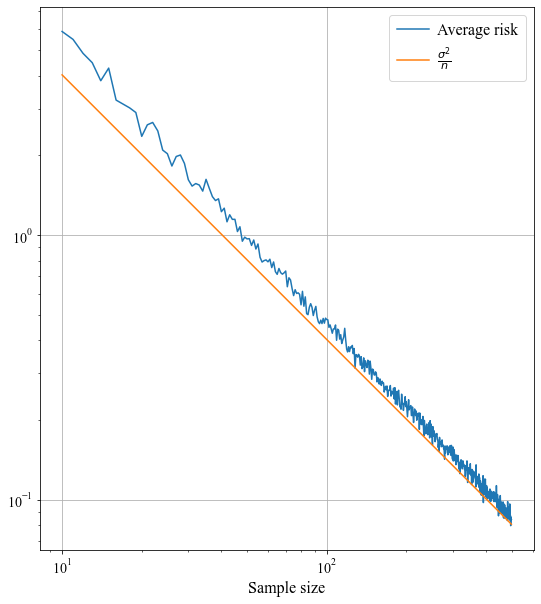

In [17]:
df_laplace.plot(figsize=(10, 10), grid=True, loglog=True).set_aspect('equal')

Since median is an MLE, we may expect its distirution to approach Normal distribution with incresing sample size, let check:

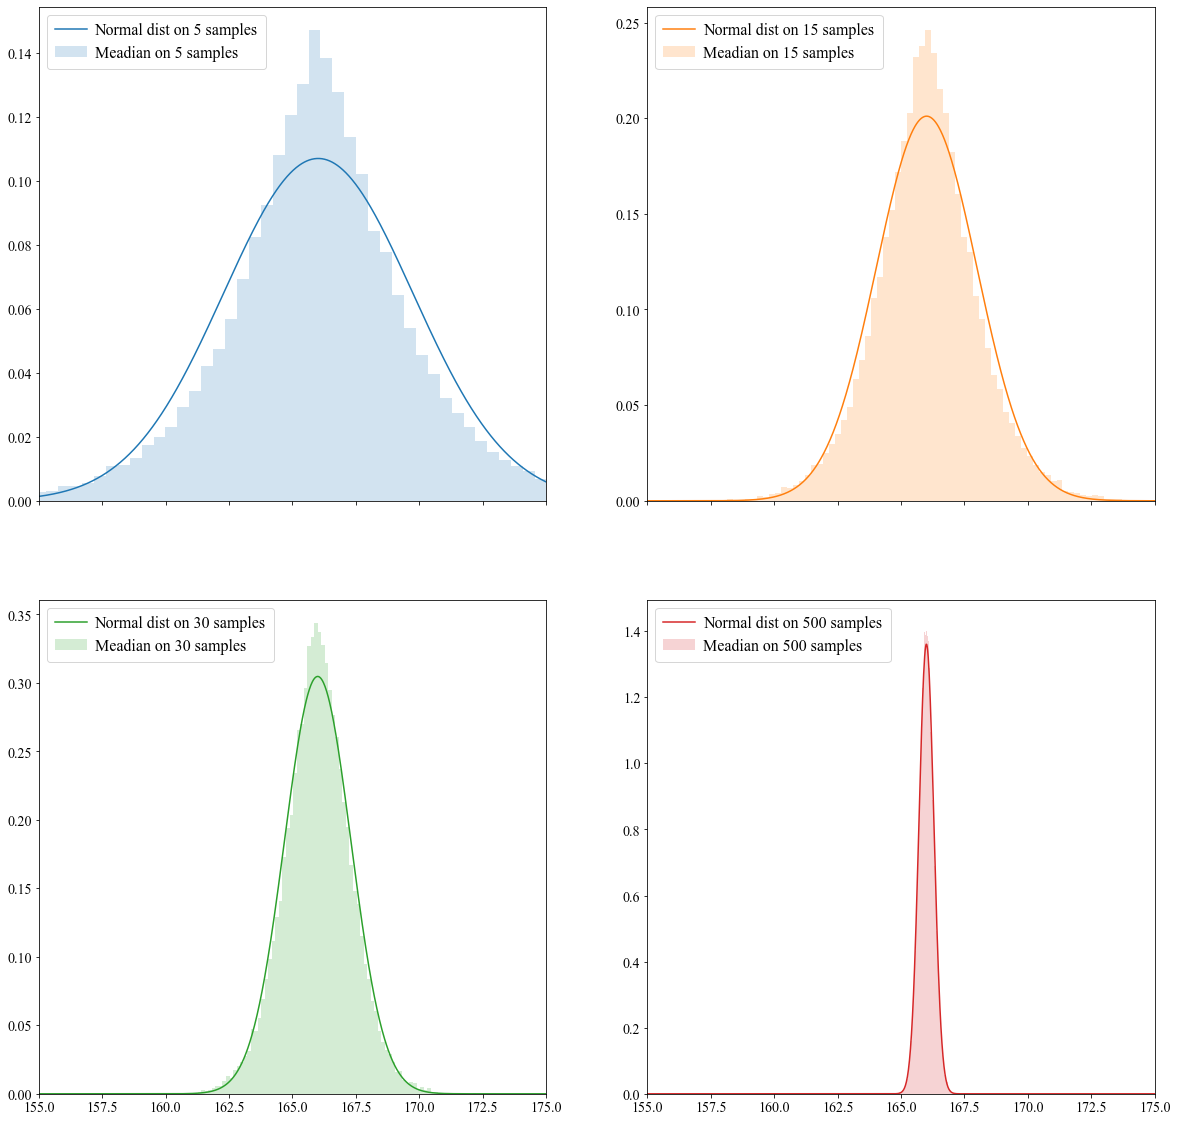

In [19]:
plot_est_hist_normal(error_gen=np.random.laplace, 
                     estimator=lambda x: np.median(x, axis=1),
                     mu=true_mu,
                     sigma=true_sigma,
                     sample_sizes=[5, 15, 30, 500],
                     num_repeats=num_repeats * 50,
                     x_min=155,
                     x_max=175)

We can see that the result holds only asymptoticaly.

In practical situations we don't know the error distribution exactly, so the median may not be an MLE. What will be the sampling distribution of the median in this case?

The following general result holds. Sample median of a random sample from a distribution with density $f(x)$ has asymptoticaly Normal distribution with mean $m$ and variance $\frac{1}{4 n f^2(m)}$, where $m$ if the median of the distribution. This is related to the so-called *robustness* of the median: it has good performance even if the underlying probability model is misspecified.

Estimating the reliability of the median (its square risk) is non-trivial. For the case of simmetric and everywhere differentiable error densities $p_{\varepsilon}$ risk asynptoticaly scales as $\frac{1}{4 n p_{\varepsilon}^2(0)}$. But how to estimate the unknown density of errors at 0? Unfotunately it is beyond the scope of this course.


### Compare mean and median for the Normal case

Using the results about the median stated above, let us return to the normal errors model and compare the risk with the mean:
$$\frac{1}{4 n p_{\varepsilon}^2(0)} = \frac{1}{4 n \left(\frac{1}{\sqrt{2\pi}\sigma} e^ {-\frac{0}{\sigma^2}}\right)^2} =  \frac{1}{4 n \frac{1}{2 \pi \sigma^2}} = \frac{\pi}{2} \frac{\sigma^2}{n}$$

In [20]:
def gaussian_errors_meadian_experiment(sample_size, mu=0, sigma=1, num_repeats=10):
    import numpy as np
    
    errors = np.random.normal(loc=0, scale=sigma, size=(num_repeats, sample_size))
    Y = mu + errors
    mY = np.median(Y, axis=1)
    r = ((mY - mu) ** 2).mean()
    return {'Sample size': sample_size, 'Average risk (median)': r}

In [21]:
exp_median = partial(gaussian_errors_meadian_experiment, 
                     mu=true_mu, 
                     sigma=true_sigma,
                     num_repeats=num_repeats)

median_risks = run_parallel(exp_median, N)

In [22]:
df_gaussian1 = pd.DataFrame(median_risks).set_index('Sample size').sort_index()
df_gaussian1["Theoretical risk (median)"] = np.pi / 2. * true_sigma ** 2 / df_gaussian1.index
df_gaussian1.head()

,Average risk (median),Theoretical risk (median)
Sample size,,
10,5.516107,6.333451
11,5.514357,5.757683
12,5.112147,5.277876
13,4.682805,4.871885
14,4.258140,4.523893


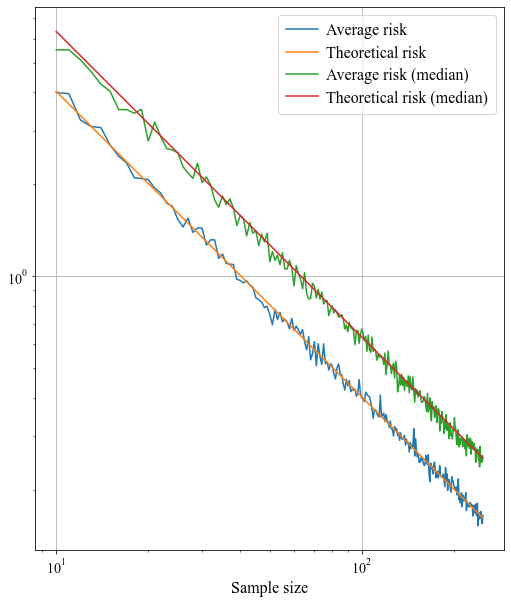

In [23]:
df_gaussian.join(df_gaussian1).plot(figsize=(10, 10), grid=True, loglog=True).set_aspect('equal')

### Cauchy errors

In the cases above we knew the true distribution of errors. What happens if we made a mistake and the true errors have a different distribution? 

One example is Cauchy distribution: it is hard to work with since mean and variance are note defined:
$$p_{\varepsilon}(z) = \frac{1}{\pi \sigma \left(1 + \left(\frac{z}{\sigma^2}\right)^2\right)}$$

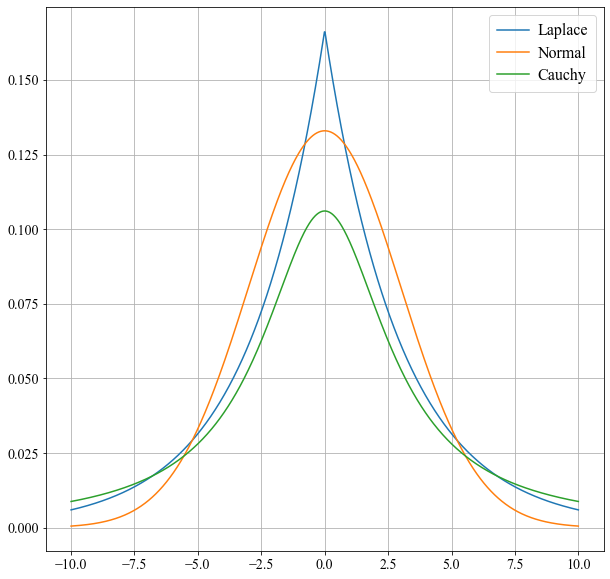

In [24]:
x = np.linspace(-10, 10, 1000)
y1 = scipy.stats.laplace(scale=3).pdf(x)
y2 = scipy.stats.norm(scale=3).pdf(x)
y3 = scipy.stats.cauchy(scale=3).pdf(x)
plt.figure(figsize=(10, 10))
plt.plot(x, y1, label='Laplace')
plt.plot(x, y2, label='Normal')
plt.plot(x, y3, label='Cauchy')
plt.legend()
plt.grid()

We repeat experiemnts with Cauchy errors and compare sample mean and sample median as estimators for $\mu$:

In [25]:
def cauchy_errors_experiment(sample_size, mu=0, sigma=1, num_repeats=10):
    import numpy as np
    import scipy
    import scipy.stats
    
    errors = scipy.stats.cauchy.rvs(scale=sigma, size=(num_repeats, sample_size))
    Y = mu + errors
    medY = np.median(Y, axis=1)
    meanY = np.mean(Y, axis=1)
    r_med = ((medY - mu) ** 2).mean()
    r_mean = ((meanY - mu) ** 2).mean()

    return {'Sample size': sample_size, 'Average risk (median)': r_med, 'Average risk (mean)': r_mean}

In [26]:
# Sample sizes to use
N = np.arange(10, 500, 1)

exp4 = partial(cauchy_errors_experiment, 
              mu=true_mu, 
              sigma=true_sigma,
              num_repeats=num_repeats)

cauchy_risks = run_parallel(exp4, N)

In [27]:
df_cauchy = pd.DataFrame(cauchy_risks).set_index('Sample size').sort_index()
df_cauchy[r"$\frac{\sigma^2}{n}$"] = true_sigma ** 2 / df_cauchy.index
df_cauchy.head()

,Average risk (median),Average risk (mean),$\frac{\sigma^2}{n}$
Sample size,,,
10,12.921785,1.299191e+05,4.032000
11,13.740341,5.465762e+04,3.665455
12,11.416655,6.043657e+07,3.360000
13,10.895738,7.830398e+03,3.101538
14,9.182665,7.867646e+03,2.880000


<AxesSubplot:xlabel='Sample size'>

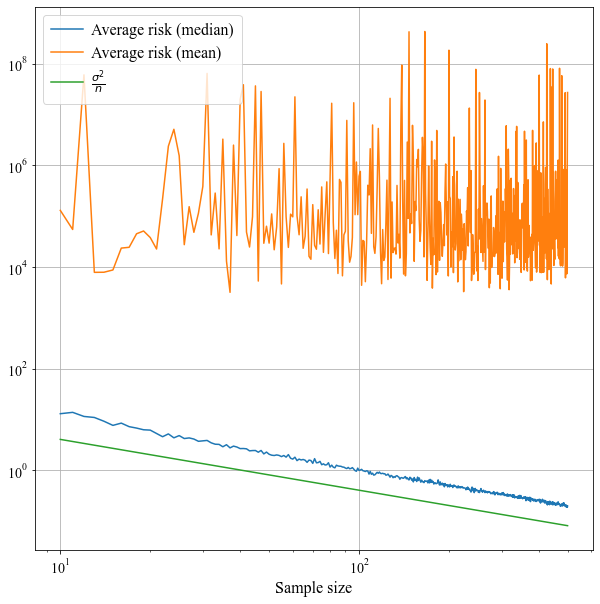

In [28]:
df_cauchy.plot(figsize=(10, 10), grid=True, loglog=True)

We can see that our estimates do not get better with the sample size if we use the sample mean. This happens because the average of a set of iid Cauchy random variables has the same distribution:
$$\overline{\varepsilon}^n = \frac{1}{n}\sum_{i=1}^{n}\varepsilon_i$$
has the same distribution as $\varepsilon_1$.

Let's see how do sampling distributions for the sample mean and sample median look like.

-1610.5025938412182 485.15852238753257
-677.6269270494299 3909.493478143632
-5878.788056978052 3630.656547042291


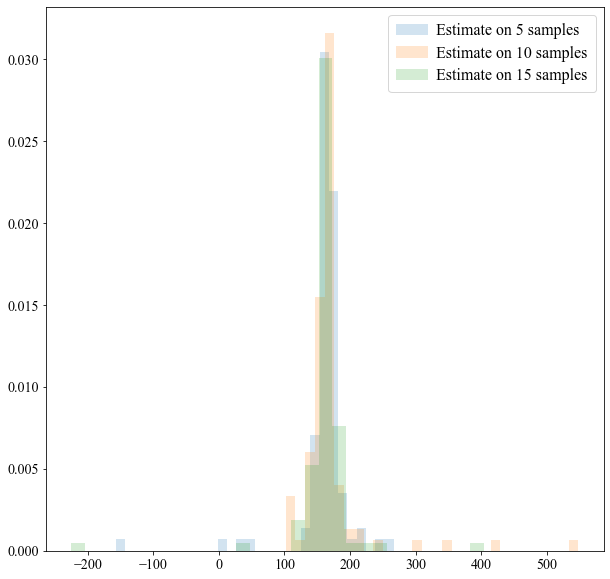

In [46]:
sample_sizes = [5, 10, 15]
min_y = 155
max_y = 175
plt.figure(figsize=(10, 10))
for n  in sample_sizes:
    errors = scipy.stats.cauchy.rvs(loc=0, scale=true_sigma, size=(100, n))
    print(errors.min(), errors.max())
    Y = true_mu + errors
    mY = Y.mean(axis=1)
    plt.hist(mY, bins=30, alpha=0.2, label=f'Estimate on {n} samples', density=True)
plt.legend()

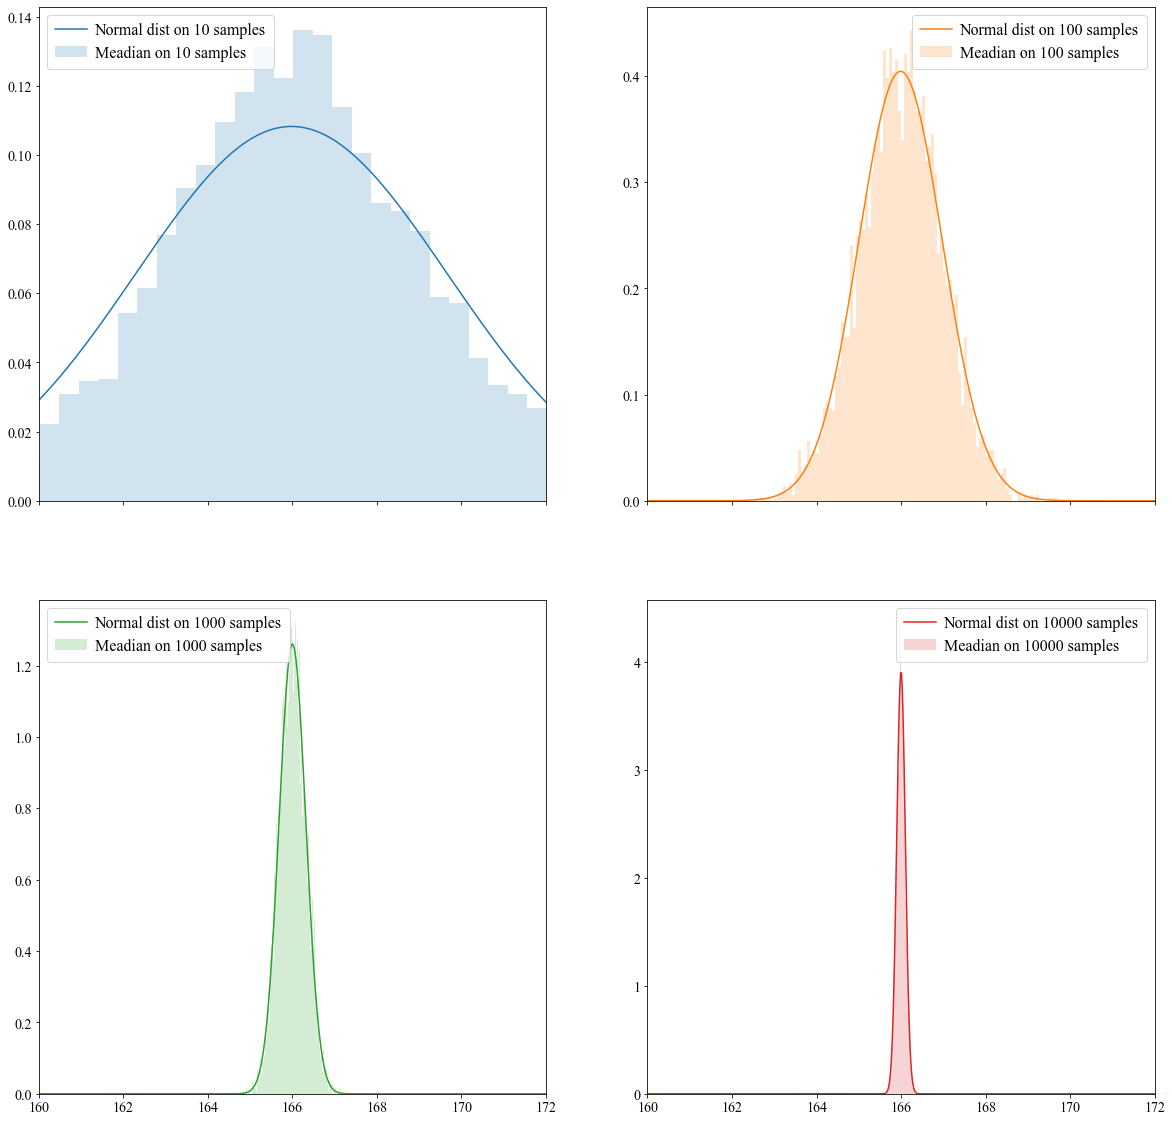

In [30]:
plot_est_hist_normal(error_gen=scipy.stats.cauchy.rvs, 
                     estimator=lambda x: np.median(x, axis=1),
                     mu=true_mu,
                     sigma=true_sigma,
                     sample_sizes=[10, 100, 1000, 10000],
                     num_repeats=num_repeats * 5,
                     x_min=160,
                     x_max=172)